# QUADRATIC FUNCTION

In [7]:
!

The folder you are executing pip from can no longer be found.


In [1]:
import numpy as np
from scipy.optimize import fmin_cobyla
from matplotlib import pylab as plt

import optimizers
from importlib import reload

In [2]:
def f(x, args):
    np.random.seed(args['seed'])
    xi = args['sigma'] * np.random.standard_normal(1)
    return 1./2 * x.T @ args['A'] @ x - args['b'].T @ x + xi

def gradient_true(x, args):
    return args['A'] @ x - args['b']

def calculate(args, optimizer, R_0, label, title):
    
    w_sol, errors, times = optimizer.search()
    iterations = range(1, len(errors)+1)

    y_label = r'print smth in here'
    
    return iterations, errors / R_0, label, times

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / args['L']

def momentum_k(k, f, nabla_f, x_k, args):
    return k / (k + 1)

In [3]:
args = {}
args['d'] = 10
args['mu'] = 1
args['L'] = 1000
args['func'] = f
args['seed'] = 42

args['gamma'] = lambda k: 1 / np.sqrt(k + 1)
args['eps'] = 0.0
args['sigma'] = 0
args['criterium'] = 'f(x_k) - f(x^*)'

args['A'] = optimizers.generate_A(args['d'], args['mu'], args['L'], args['seed'])
np.random.seed(args['seed'])
args['b'] = np.random.random_sample(args['d'])
args['b'] = np.zeros(args['d'])

# Finding x_sol

In [6]:
reload(optimizers)

def fw_step(k, func, nabla_f, x_curr, args):
    return 2 / (k + 3)

def momentum_fw(k, f, nabla_f, x_k, args):
    return (k+1) / (k + 3)

args['momentum_k'] = momentum_fw
args['max_steps'] = 10**5
args['batch_size'] = 1
args['use_proj'] = False
args['criterium'] = 'f(x_k+1) - f(x_k)'
np.random.seed(args['seed'])
w_0 = np.random.random_sample(args['d'])

### l_1 ball ###
args['set'] = 'l1_ball'
w_0_l1 = w_0 / np.linalg.norm(w_0, ord=1)
w_true_sol_l1, _ , _ = optimizers.MBFWOptimizer(f, gradient_true, 
                                                x_0 = w_0_l1,
                                                step = fw_step, 
                                                args = args).search()
R_0_l1 = f(w_0_l1, args) - f(w_true_sol_l1, args)

### l_2 ball ###
args['set'] = 'l2_ball'
w_0_l2 = w_0 / np.linalg.norm(w_0, ord=2)
w_true_sol_l2, _ , _ = optimizers.MBFWOptimizer(f, gradient_true, 
                                                x_0 = w_0_l2,
                                                step = fw_step, 
                                                args = args).search()
R_0_l2 = f(w_0_l2, args) - f(w_true_sol_l2, args)

### simplex ###
args['set'] = 'simplex'
w_0_simp = np.abs(w_0) / np.linalg.norm(w_0, ord=1)
w_true_sol_simp, _ , _ = optimizers.MBFWOptimizer(f, gradient_true, 
                                                x_0 = w_0_simp,
                                                step = fw_step, 
                                                args = args).search()
R_0_simp = f(w_0_simp, args) - f(w_true_sol_simp, args)

100%|██████████| 100000/100000 [00:02<00:00, 45892.65it/s]


# Different metods

## MBFW

In [9]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
#####
args['grad_curr'] = np.zeros(args['d'])
######
iterations_mbfw = []
errors_mbfw = []
labels_mbfw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_opf_jaguar],
                          ['TPF', 'OPF']):
        args['set'] = Q
        args['oracle_counter'] = 0
        args['oracle_calls'] = []
        optimizer = optimizers.MBFWOptimizer(f, grad, x_0 = w_0, 
                                             step = fw_step, args = args)

        label = f'MBFW, {name}, {Q}'

        _, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_mbfw.append(args['oracle_calls'])
        errors_mbfw.append(errors)
        labels_mbfw.append(label)

100%|██████████| 10000/10000 [00:00<00:00, 23948.65it/s]


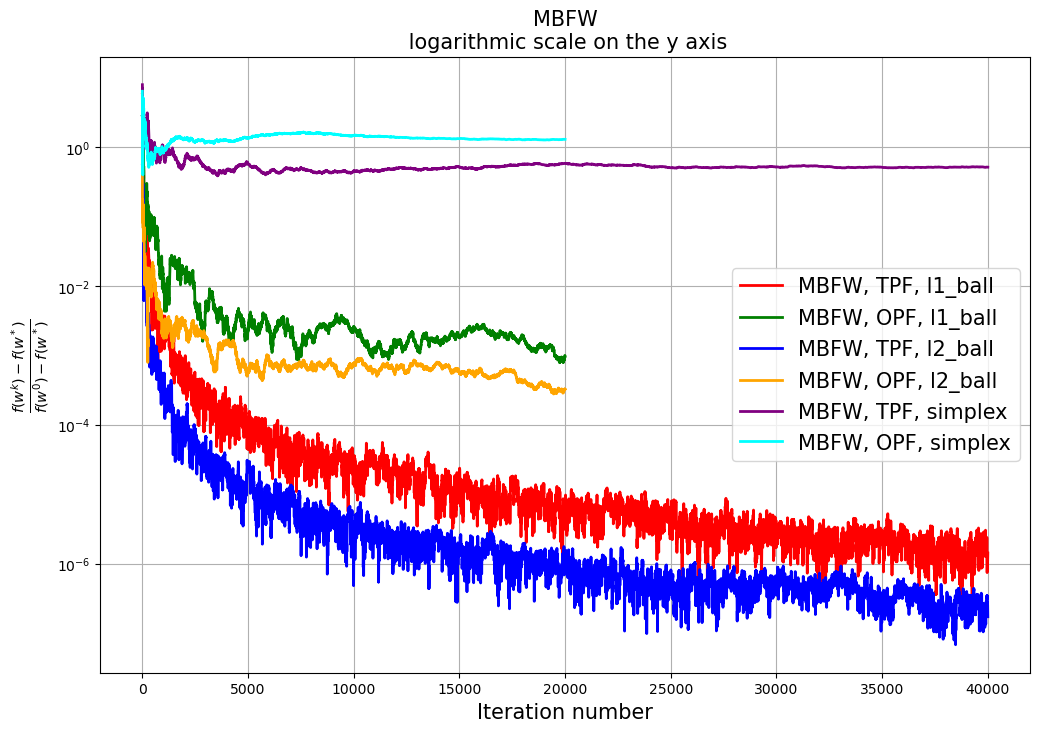

In [10]:
title = "MBFW"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_mbfw, errors_mbfw, y_label=y_label,
                     labels=labels_mbfw, title=title, markers=[None]*100)

## FW

In [16]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_fw = []
errors_fw = []
labels_fw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_opf_jaguar],
                          ['TPF', 'OPF']):
        args['set'] = Q
        optimizer = optimizers.FWOptimizer(f, grad, x_0 = w_0, 
                                           step = fw_step, args = args)

        label = f'FW, {name}, {Q}'

        iterations, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_fw.append(iterations)
        errors_fw.append(errors)
        labels_fw.append(label)

100%|██████████| 10000/10000 [00:00<00:00, 17892.48it/s]


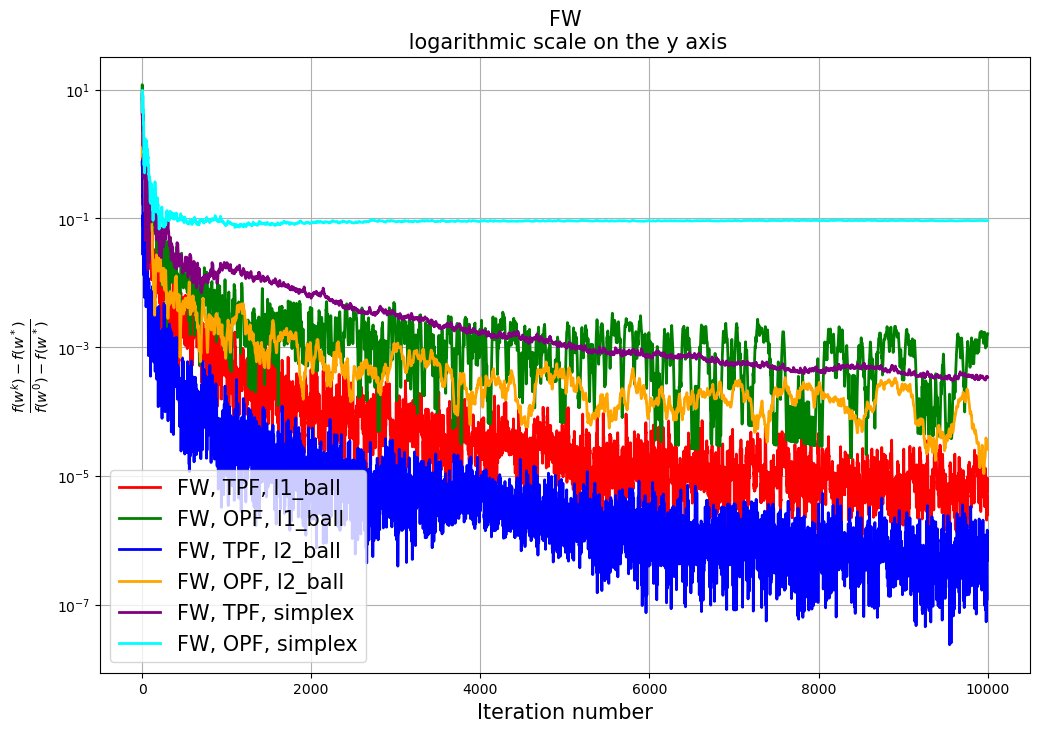

In [17]:
title = "FW"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fw, errors_fw, y_label=y_label,
                         labels=labels_fw, title=title, markers=[None]*100)

## Projection

In [14]:
def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (args['c'] * args['L'])

In [20]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 5
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = True
args['gamma'] = lambda k: 1e-1

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_proj = []
errors_proj = []
labels_proj = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_opf_jaguar],
                          ['TPF', 'OPF']):
        args['set'] = Q
        if name == 'TPF':
            args['c'] = 50
        else:
            args['c'] = 500
        optimizer = optimizers.GDOptimizer(f, grad, x_0 = w_0, 
                                           step = const_gamma, args = args)

        label = f'Projection, {name}, {Q}'

        iterations, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_proj.append(iterations)
        errors_proj.append(errors)
        labels_proj.append(label)

100%|██████████| 100000/100000 [00:07<00:00, 12681.05it/s]


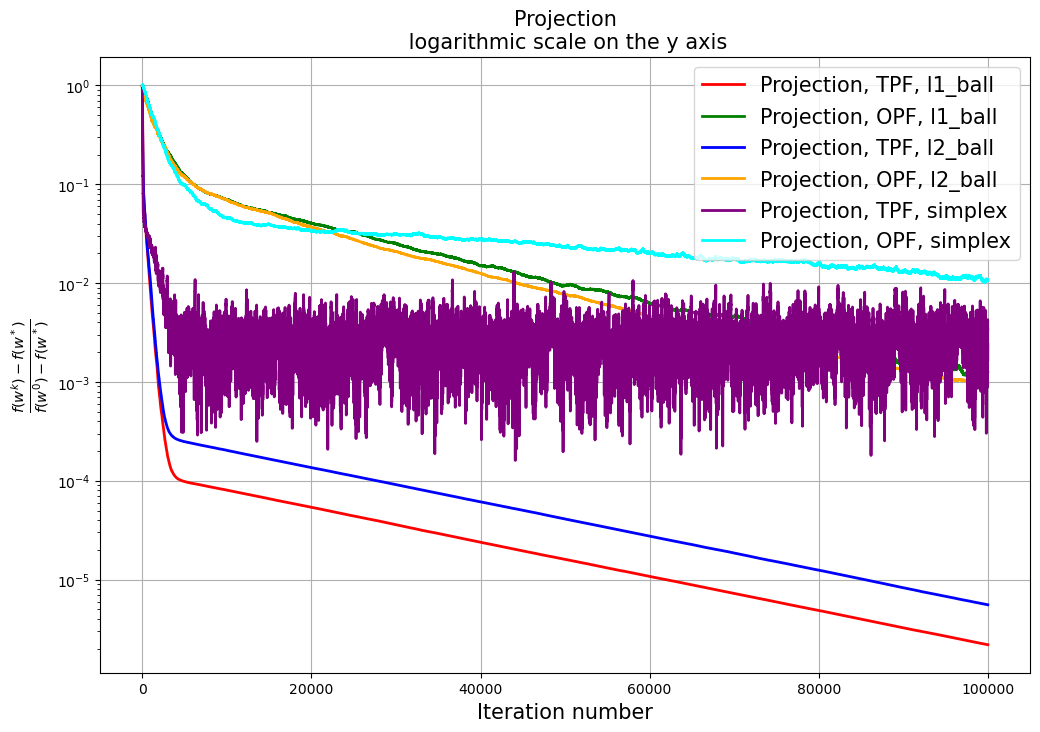

In [21]:
title = "Projection"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_proj, errors_proj, y_label=y_label,
                         labels=labels_proj, title=title, markers=[None]*100)

## FZCGS

In [7]:
def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (args['c'] * args['L'])
def eta(k, func, nabla_f, x_curr, args):
    return args['eta_0']/(k+1)

In [11]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['gamma'] = lambda k: 1e-1
args['eta'] = eta
#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_fzcgs = []
errors_fzcgs = []
labels_fzcgs = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_opf_jaguar],
                          ['TPF', 'OPF']):
        args['set'] = Q
        if args['set'] == 'simplex':
            args['c'] = 100.
            args['eta_0'] = 30.
        else:
            args['c'] = 100.
            args['eta_0'] = 10.
        args['oracle_counter'] = 0
        args['oracle_calls'] = []
        optimizer = optimizers.FZCGSOptimizer(f, grad, x_0 = w_0, 
                                              step = const_gamma, args = args)

        label = f'FZCGS, {name}, {Q}'

        _, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_fzcgs.append(args['oracle_calls'])
        errors_fzcgs.append(errors)
        labels_fzcgs.append(label)

100%|██████████| 10000/10000 [00:02<00:00, 4237.38it/s]


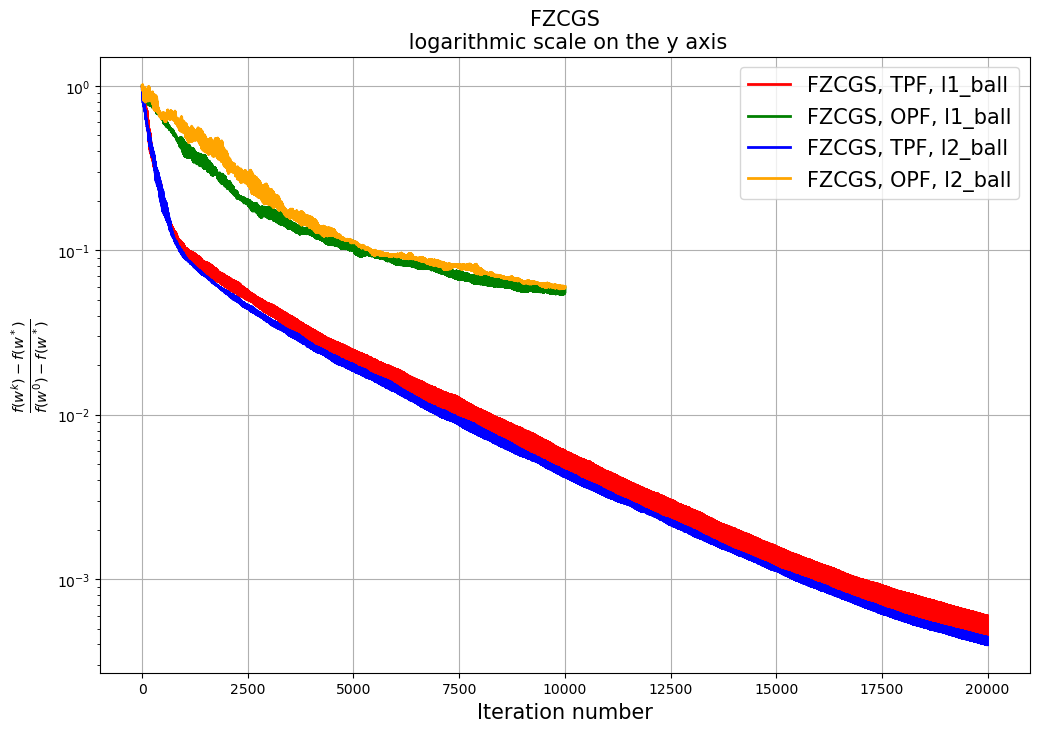

In [12]:
title = "FZCGS"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fzcgs, errors_fzcgs, y_label=y_label,
                         labels=labels_fzcgs, title=title, markers=[None]*100)

# Different grdient methods 

## MBFW TPF

In [15]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['norm'] = 1

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_mbfw = []
errors_mbfw = []
labels_mbfw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_tpf_lame_v1,
                           optimizers.get_grad_tpf_lame_v2],
                          ['TPF jaguar', 'TPF lame', 'TPF turtle']):
        if name == 'TPF jaguar':
            args['jaguar'] = True
        else:
            args['jaguar'] = False
        args['set'] = Q
        args['oracle_counter'] = 0
        args['oracle_calls'] = []
        optimizer = optimizers.MBFWOptimizer(f, grad, x_0 = w_0, 
                                             step = fw_step, args = args)

        label = f'MBFW, {name}, {Q}'

        _, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_mbfw.append(args['oracle_calls'])
        errors_mbfw.append(errors)
        labels_mbfw.append(label)

100%|██████████| 10000/10000 [00:01<00:00, 5592.65it/s]


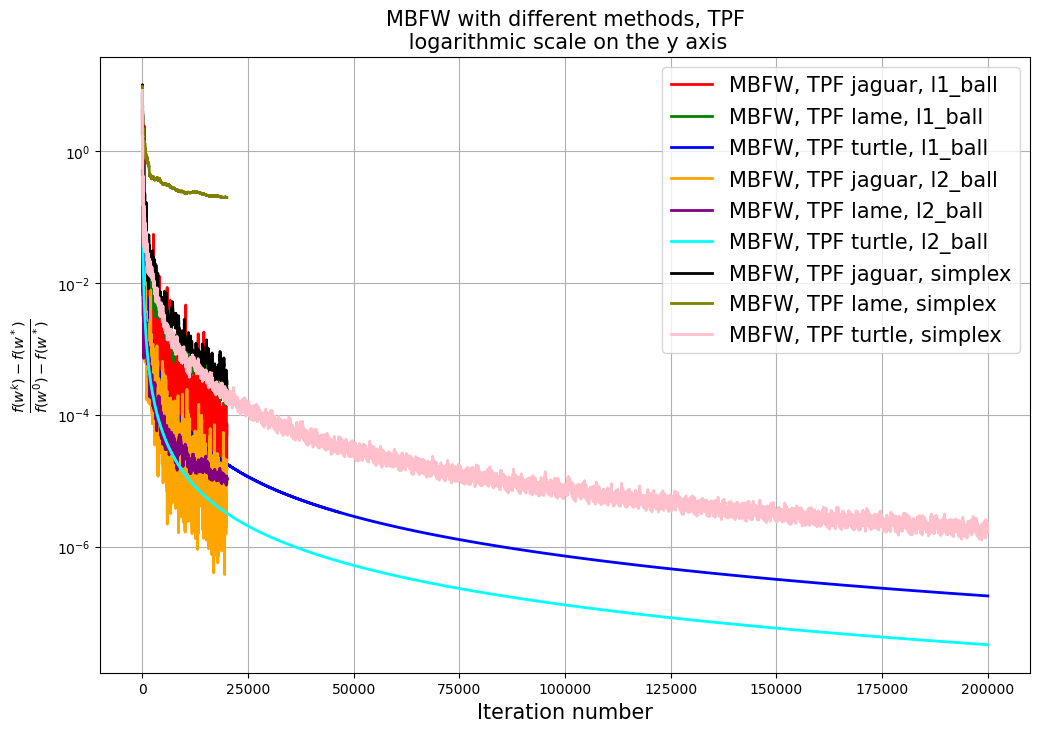

In [16]:
title = "MBFW with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_mbfw, errors_mbfw, y_label=y_label,
                         labels=labels_mbfw, title=title, markers=[None]*100)

## FW TPF

In [22]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['norm'] = 1
args['p'] = 1. / (args['d'] - 1)

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_fw = []
errors_fw = []
labels_fw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_tpf_lame_v1,
                           optimizers.get_grad_tpf_lame_v2],
                          ['TPF jaguar', 'TPF lame', 'TPF turtle']):
        args['set'] = Q
        args['oracle_counter'] = 0
        args['oracle_calls'] = []
        args['batch_size'] = 1
        if name == 'TPF jaguar':
            args['jaguar'] = True
        else:
            args['jaguar'] = False
        optimizer = optimizers.FWOptimizer(f, grad, x_0 = w_0, 
                                           step = fw_step, args = args)

        label = f'FW, {name}, {Q}'

        _, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_fw.append(args['oracle_calls'])
        errors_fw.append(errors)
        labels_fw.append(label)

100%|██████████| 10000/10000 [00:01<00:00, 5568.19it/s]


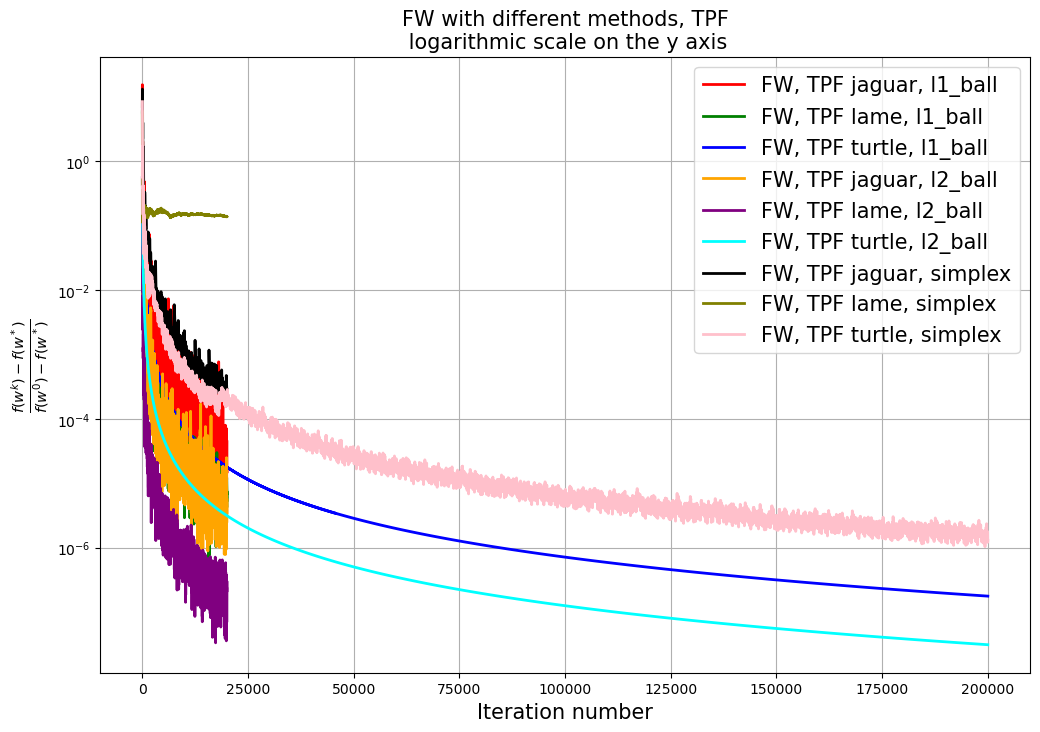

In [23]:
title = "FW with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fw, errors_fw, y_label=y_label,
                         labels=labels_fw, title=title, markers=[None]*100)

## Projection TPF

In [44]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = True
args['norm'] = 1
args['c'] = 50
args['p'] = 1./ (args['d'] - 1)

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_proj = []
errors_proj = []
labels_proj = []
# 'l2_ball', 'simplex'
for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'sim[lex]'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_tpf_lame_v1, 
                           optimizers.get_grad_tpf_lame_v2],
                          ['TPF jaguar', 'TPF lame', 'TPF turtle']):
        args['set'] = Q
        args['oracle_counter'] = 0
        args['oracle_calls'] = []
        optimizer = optimizers.GDOptimizer(f, grad, x_0 = w_0, 
                                           step = const_gamma, args = args)

        label = f'Projection, {name}, {Q}'

        _, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_proj.append(args['oracle_calls'])
        errors_proj.append(errors)
        labels_proj.append(label)

100%|██████████| 10000/10000 [00:02<00:00, 4652.66it/s]


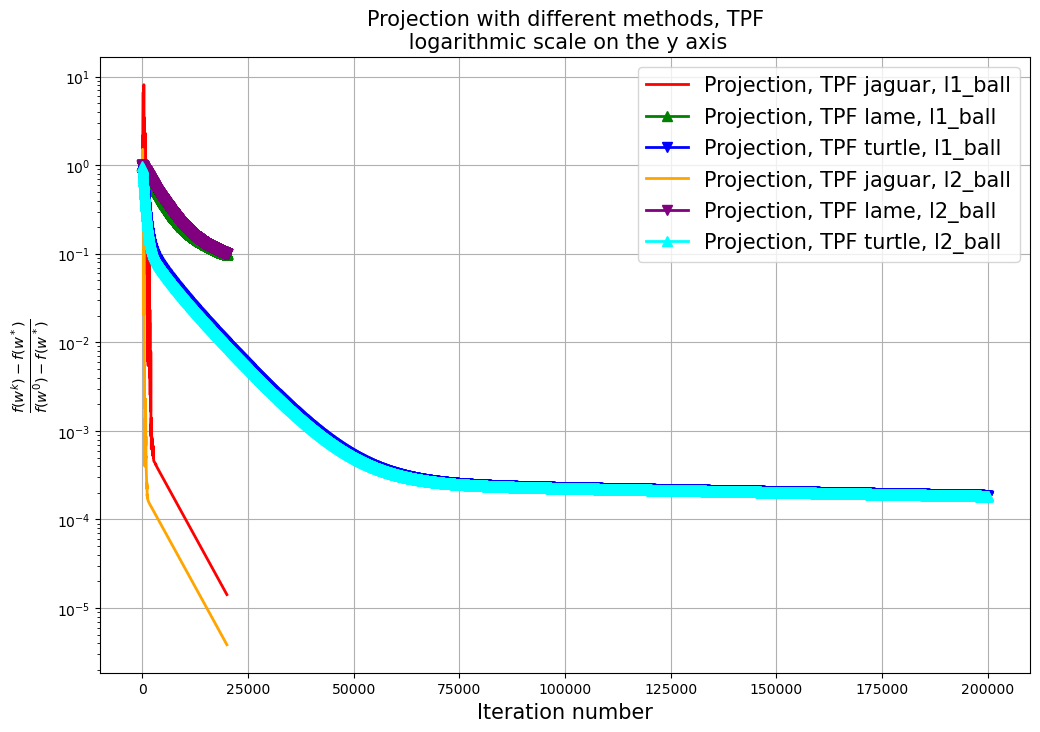

In [52]:
title = "Projection with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_proj, errors_proj, y_label=y_label,
                         labels=labels_proj, title=title, 
                         markers=[None, "^", "v", None, "v", "^"])

## FZCGS TPF

In [39]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['gamma'] = lambda k: 1e-1
args['eta'] = eta
args['c'] = 100.
args['eta_0'] = 1.
args['norm'] = 1.

#####
args['grad_curr'] = np.zeros(args['d'])
######



iterations_fzcgs = []
errors_fzcgs = []
labels_fzcgs = []

for Q, w_0, R_0, w_sol in zip(['l1_ball'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_tpf_lame_v1],
                          ['TPF jaguar', 'TPF lame']):
        args['set'] = Q

        optimizer = optimizers.FZCGSOptimizer(f, grad, x_0 = w_0, 
                                              step = const_gamma, args = args)

        label = f'FZCGS, {name}, {Q}'

        iterations, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_fzcgs.append(iterations)
        errors_fzcgs.append(errors)
        labels_fzcgs.append(label)

  3%|▎         | 342/10000 [00:37<17:31,  9.18it/s]  


KeyboardInterrupt: 

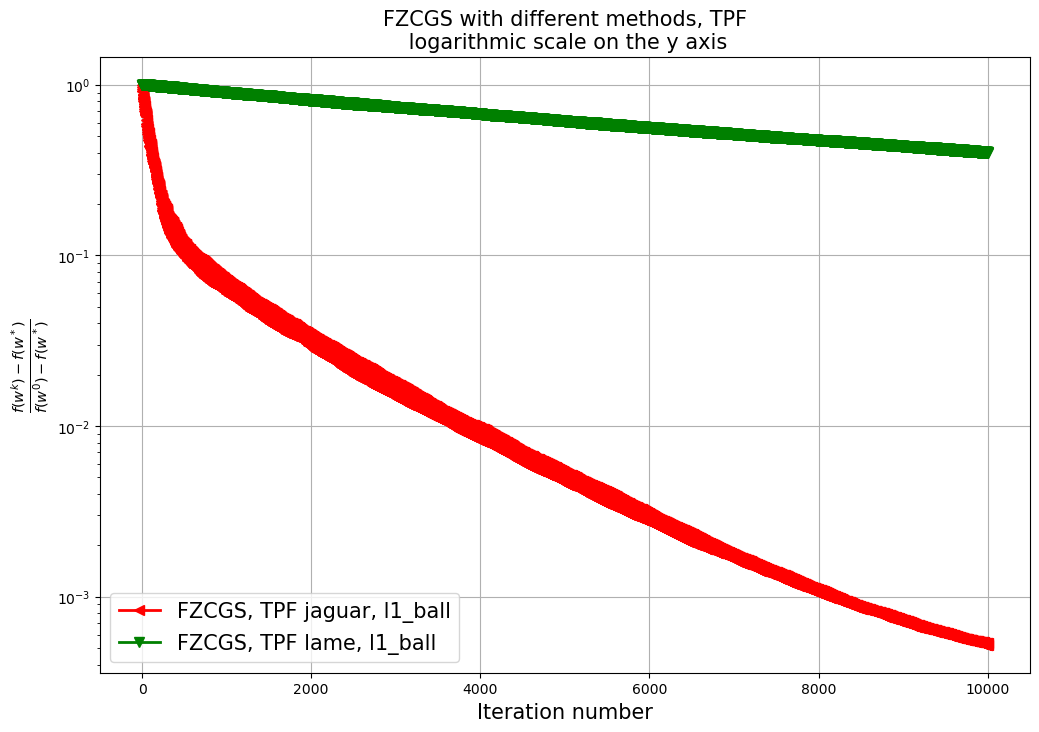

In [83]:
title = "FZCGS with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fzcgs, errors_fzcgs, y_label=y_label,
                         labels=labels_fzcgs, title=title, markers=['<', 'v', '^', '>'])

## MBFW OPF

In [40]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 5
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['norm'] = 1

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_mbfw = []
errors_mbfw = []
labels_mbfw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_opf_jaguar, 
                           optimizers.get_grad_opf_lame],
                          ['OPF jaguar', 'OPF lame']):
        args['set'] = Q
        optimizer = optimizers.MBFWOptimizer(f, grad, x_0 = w_0, 
                                             step = fw_step, args = args)

        label = f'MBFW, {name}, {Q}'

        iterations, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_mbfw.append(iterations)
        errors_mbfw.append(errors)
        labels_mbfw.append(label)

100%|██████████| 100000/100000 [00:05<00:00, 19153.62it/s]


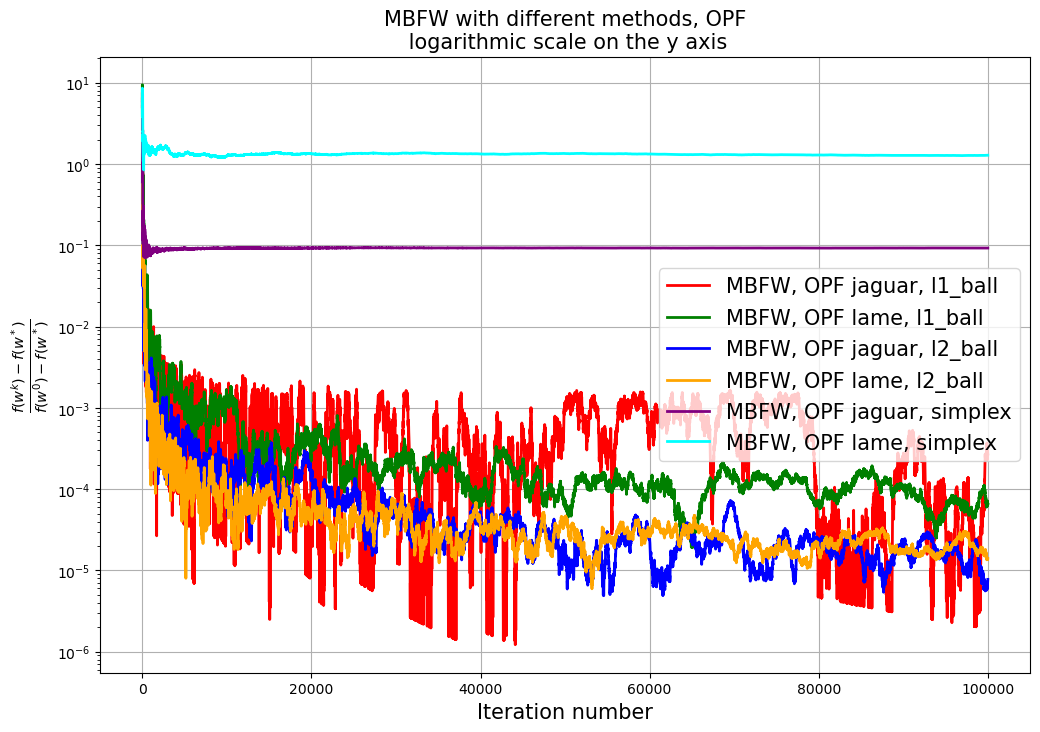

In [41]:
title = "MBFW with different methods, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_mbfw, errors_mbfw, y_label=y_label,
                         labels=labels_mbfw, title=title, markers=[None]*100)

## FW OPF

In [42]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 5
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['norm'] = 1

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_fw = []
errors_fw = []
labels_fw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_opf_jaguar, 
                           optimizers.get_grad_opf_lame],
                          ['OPF jaguar', 'OPF lame']):
        args['set'] = Q
        optimizer = optimizers.FWOptimizer(f, grad, x_0 = w_0, 
                                           step = fw_step, args = args)

        label = f'FW, {name}, {Q}'

        iterations, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_fw.append(iterations)
        errors_fw.append(errors)
        labels_fw.append(label)

100%|██████████| 100000/100000 [00:05<00:00, 19894.76it/s]


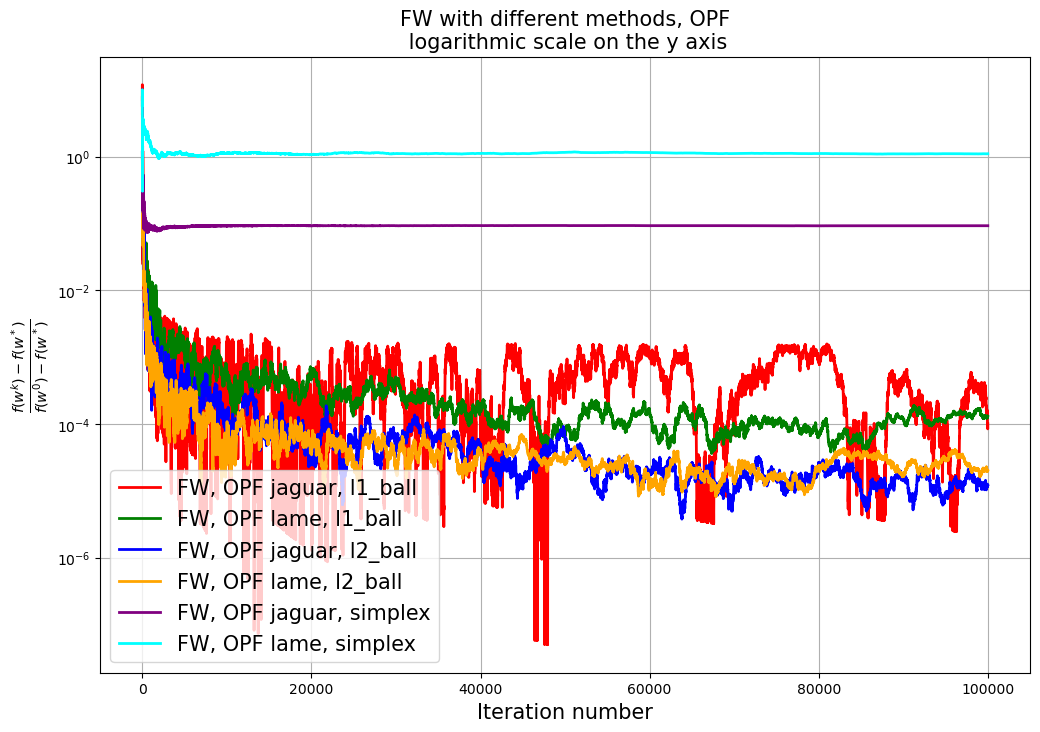

In [43]:
title = "FW with different methods, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fw, errors_fw, y_label=y_label,
                         labels=labels_fw, title=title, markers=[None]*100)

## Projection OPF

In [44]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 5
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = True
args['norm'] = 1
args['c'] = 300

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_proj = []
errors_proj = []
labels_proj = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_opf_jaguar, 
                           optimizers.get_grad_opf_lame],
                          ['OPF jaguar', 'OPF lame']):
        args['set'] = Q
        optimizer = optimizers.GDOptimizer(f, grad, x_0 = w_0, 
                                           step = const_gamma, args = args)

        label = f'Projection, {name}, {Q}'

        iterations, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_proj.append(iterations)
        errors_proj.append(errors)
        labels_proj.append(label)

100%|██████████| 100000/100000 [00:11<00:00, 8667.36it/s]


НЕ ТРОГАТЬ

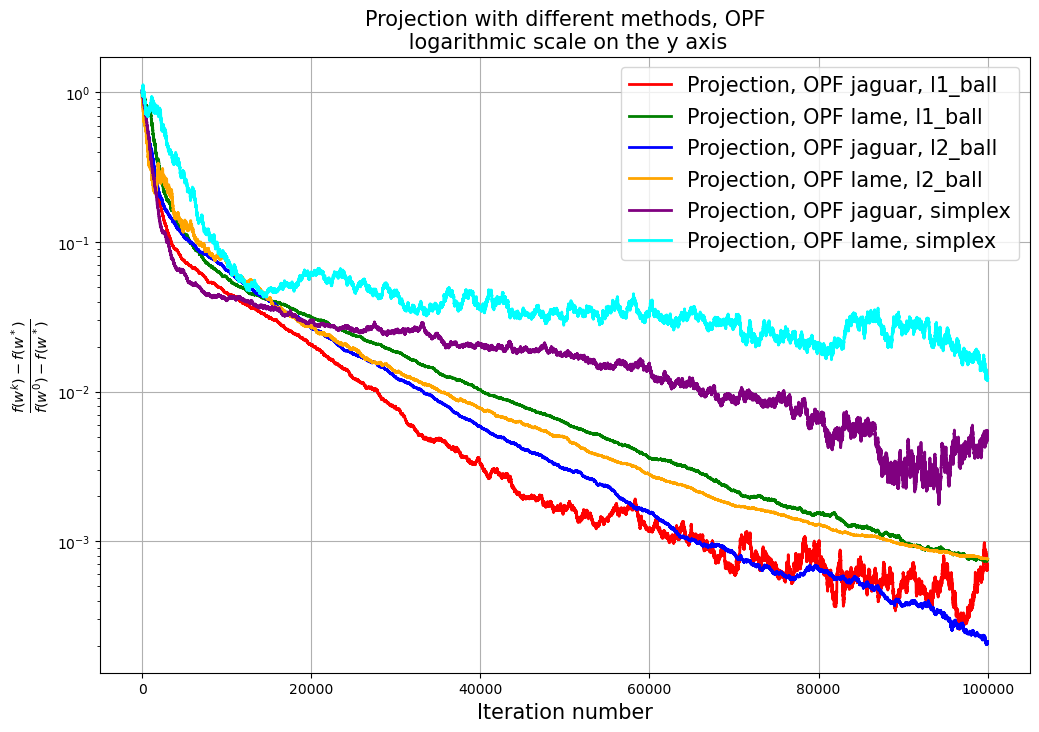

In [45]:
title = "Projection with different methods, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_proj, errors_proj, y_label=y_label,
                         labels=labels_proj, title=title, markers=[None]*100)